In [59]:
from pyexpat import features
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeRegressor, export_text
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error
import xgboost as xgb

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score
%matplotlib inline

In [2]:
import urllib.request

url = "https://github.com/alexeygrigorev/datasets/raw/refs/heads/master/jamb_exam_results.csv"
filename = 'data/data.csv'
urllib.request.urlretrieve(url, filename)

('data/data.csv', <http.client.HTTPMessage at 0x1ebf68987a0>)

In [3]:
df = pd.read_csv(filename)

In [4]:
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Student_ID,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,1,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,2,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,3,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,4,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,5,22,Female,Medium,Tertiary,1


### Preparing the dataset 

First, let's make the names lowercase:

```python
df.columns = df.columns.str.lower().str.replace(' ', '_')
```

Preparation:

* Remove the `student_id` column.
* Fill missing values with zeros.
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1.
* Use `DictVectorizer(sparse=True)` to turn the dataframes into matrices.

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [7]:
df = df.drop(columns =["student_id"])

In [8]:
df.describe()

,jamb_score,study_hours_per_week,attendance_rate,teacher_quality,distance_to_school,age,assignments_completed
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,174.074600,19.521200,84.235200,2.521400,10.005460,18.445800,1.804600
std,47.616477,9.634569,9.485688,0.985564,4.820221,2.301504,0.992076
min,100.000000,0.000000,50.000000,1.000000,0.000000,15.000000,1.000000
25%,135.000000,13.000000,78.000000,2.000000,6.600000,16.000000,1.000000
50%,170.000000,19.000000,84.000000,2.000000,10.000000,18.000000,1.000000
75%,209.000000,26.000000,91.000000,3.000000,13.400000,20.000000,2.000000
max,367.000000,40.000000,100.000000,5.000000,20.000000,22.000000,5.000000


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   jamb_score                    5000 non-null   int64  
 1   study_hours_per_week          5000 non-null   int64  
 2   attendance_rate               5000 non-null   int64  
 3   teacher_quality               5000 non-null   int64  
 4   distance_to_school            5000 non-null   float64
 5   school_type                   5000 non-null   object 
 6   school_location               5000 non-null   object 
 7   extra_tutorials               5000 non-null   object 
 8   access_to_learning_materials  5000 non-null   object 
 9   parent_involvement            5000 non-null   object 
 10  it_knowledge                  5000 non-null   object 
 11  age                           5000 non-null   int64  
 12  gender                        5000 non-null   object 
 13  soc

In [10]:
df['parent_education_level'].value_counts()

parent_education_level
Secondary    1556
Primary      1335
Tertiary     1218
Name: count, dtype: int64

In [20]:
df['parent_education_level'] = df['parent_education_level'].fillna('Missing')

In [22]:
df.isnull().sum()

jamb_score                      0
study_hours_per_week            0
attendance_rate                 0
teacher_quality                 0
distance_to_school              0
school_type                     0
school_location                 0
extra_tutorials                 0
access_to_learning_materials    0
parent_involvement              0
it_knowledge                    0
age                             0
gender                          0
socioeconomic_status            0
parent_education_level          0
assignments_completed           0
dtype: int64

In [24]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
df_full_train = df_full_train.reset_index(drop=True)

y_train = df_train.jamb_score.values
y_val = df_val.jamb_score.values
y_test = df_test.jamb_score.values
y_full_train = df_full_train.jamb_score.values

del df_train["jamb_score"]
del df_val["jamb_score"]
del df_test["jamb_score"]
del df_full_train['jamb_score']

len(df_train), len(df_val), len(df_test), len(df_full_train)

(3000, 1000, 1000, 4000)

In [26]:
dv = DictVectorizer(sparse=True)

In [27]:
train_dicts = df_train.to_dict(orient='records')
val_dicts = df_val.to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)
X_val = dv.transform(val_dicts)
# full_train_dicts = df_full_train.to_dict(orient='records')
# test_dicts = df_test.to_dict(orient='records')
# X_test = dv.transform(test_dicts)
# X_full_train = dv.transform(train_dicts)

## Question 1

Let's train a decision tree regressor to predict the `jamb_score` variable. 

* Train a model with `max_depth=1`.


Which feature is used for splitting the data?

* `study_hours_per_week`
* `attendance_rate`
* `teacher_quality`
* `distance_to_school`

In [31]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [32]:
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- study_hours_per_week <= 18.50
|   |--- value: [155.24]
|--- study_hours_per_week >  18.50
|   |--- value: [188.59]



## Question 2

Train a random forest regressor with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1` (optional - to make training faster)


What's the RMSE of this model on the validation data?

* 22.13
* 42.13
* 62.13
* 82.12

In [36]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

41.82546234054084

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10.
* Set `random_state` to `1`.
* Evaluate the model on the validation dataset.


After which value of `n_estimators` does RMSE stop improving?
Consider 3 decimal places for calculating the answer.

- 10
- 25
- 80
- 200

In [37]:
scores = []
for n in range(10,201,10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_val)
    scores.append((n, root_mean_squared_error(y_val, y_pred)))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

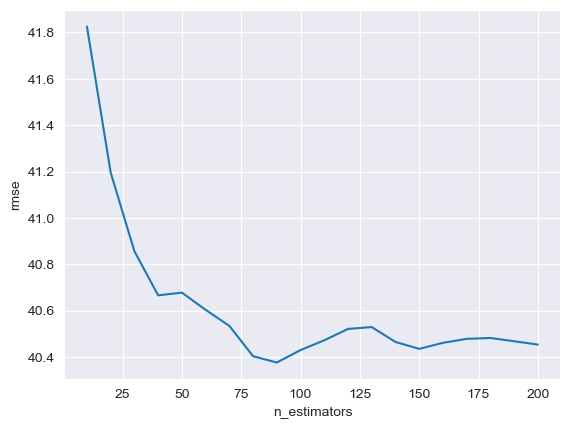

In [38]:
plt.plot(df_scores['n_estimators'], df_scores['rmse'])
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.show()

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values,
  * try different values of `n_estimators` from 10 till 200 (with step 10)
  * calculate the mean RMSE 
* Fix the random seed: `random_state=1`


What's the best `max_depth`, using the mean RMSE?

* 10
* 15
* 20
* 25

In [41]:
scores = []
max_depth = [10, 15, 20, 25]
for d in max_depth:
    for n in range(10,201,10):
        rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1, max_depth=d)
        rf.fit(X_train, y_train)
    
        y_pred = rf.predict(X_val)
        scores.append((n, d, root_mean_squared_error(y_val, y_pred)))
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'max_depth', 'rmse'])

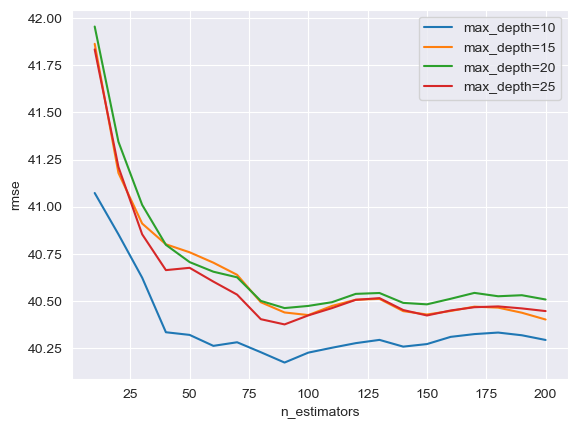

In [42]:
for d in max_depth:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset['n_estimators'], df_subset['rmse'], label='max_depth=%d' % d)
    plt.xlabel('n_estimators')
    plt.ylabel('rmse')
plt.legend()
plt.show()

# Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorithm, it finds the best split. 
When doing it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the important features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parameters:
  * `n_estimators=10`,
  * `max_depth=20`,
  * `random_state=1`,
  * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature (among these 4)? 

* `study_hours_per_week`
* `attendance_rate`
* `distance_to_school`
* `teacher_quality`


In [44]:
rf = RandomForestRegressor(max_depth=20, random_state=1, n_estimators=10, n_jobs = -1)
rf.fit(X_train, y_train)


RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [45]:
rf.feature_importances_

array([0.01093634, 0.01014068, 0.06981166, 0.03049321, 0.14898619,
       0.13492521, 0.01018578, 0.01170238, 0.01063523, 0.0088544 ,
       0.01757751, 0.01215927, 0.01102292, 0.01163625, 0.01497637,
       0.01496113, 0.01423605, 0.02199681, 0.01400047, 0.01108758,
       0.00998864, 0.00825745, 0.0095368 , 0.007989  , 0.02570122,
       0.00975894, 0.00986943, 0.24633057, 0.08224251])

In [56]:
dv.get_feature_names_out()

array(['access_to_learning_materials=No',
       'access_to_learning_materials=Yes', 'age', 'assignments_completed',
       'attendance_rate', 'distance_to_school', 'extra_tutorials=No',
       'extra_tutorials=Yes', 'gender=Female', 'gender=Male',
       'it_knowledge=High', 'it_knowledge=Low', 'it_knowledge=Medium',
       'parent_education_level=Missing', 'parent_education_level=Primary',
       'parent_education_level=Secondary',
       'parent_education_level=Tertiary', 'parent_involvement=High',
       'parent_involvement=Low', 'parent_involvement=Medium',
       'school_location=Rural', 'school_location=Urban',
       'school_type=Private', 'school_type=Public',
       'socioeconomic_status=High', 'socioeconomic_status=Low',
       'socioeconomic_status=Medium', 'study_hours_per_week',
       'teacher_quality'], dtype=object)

In [57]:
df_feature_imp = pd.DataFrame( rf.feature_importances_, columns=['feature_importance'])
df_feature_imp['features'] = dv.get_feature_names_out()
df_feature_imp.sort_values('feature_importance', ascending=False)

,feature_importance,features
27,0.246331,study_hours_per_week
4,0.148986,attendance_rate
5,0.134925,distance_to_school
28,0.082243,teacher_quality
2,0.069812,age
3,0.030493,assignments_completed
24,0.025701,socioeconomic_status=High
17,0.021997,parent_involvement=High
10,0.017578,it_knowledge=High
14,0.014976,parent_education_level=Primary


## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter:

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` from `0.3` to `0.1`.

Which eta leads to the best RMSE score on the validation dataset?

* 0.3
* 0.1
* Both give equal value

In [92]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')
        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])
        results.append((it, train, val))
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [93]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]
xgb_params = {
        'eta': 0.3, 
        'max_depth': 6,
        'min_child_weight': 1,
        
        'objective': 'reg:squarederror',
        'nthread': 8,
        
        'seed': 1,
        'verbosity': 1,
    }
rmse = []

In [94]:
%%capture output_0_3

xgb_params['eta'] = 0.3
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals = watchlist)    
y_pred = model.predict(dval)
rmse.append((xgb_params['eta'], root_mean_squared_error(y_val, y_pred)))

In [95]:
%%capture output_0_1

xgb_params['eta'] = 0.1
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals = watchlist)  
y_pred = model.predict(dval)
rmse.append((xgb_params['eta'], root_mean_squared_error(y_val, y_pred)))

In [96]:
scores = {}
scores['eta=0.3'] = parse_xgb_output(output_0_3)
scores['eta=0.1'] = parse_xgb_output(output_0_1)

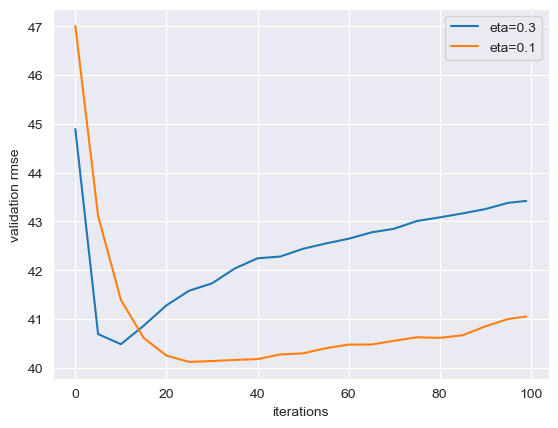

In [97]:
for eta in scores.keys():
    df_score = scores[eta]
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
plt.xlabel('iterations')
plt.ylabel('validation rmse')
plt.legend()
plt.show()

In [98]:
print(rmse)

[(0.3, 43.418817345871766), (0.1, 41.05034017683498)]
